<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing Lidar Data from USGS 3Dep program
## This notebook demonstrates how to process lidar data using [raster_tools](https://pypi.org/project/raster-tools/), delayed processing, and automated scheduling for parallel processes 

### Author John Hogland 3/13/2023

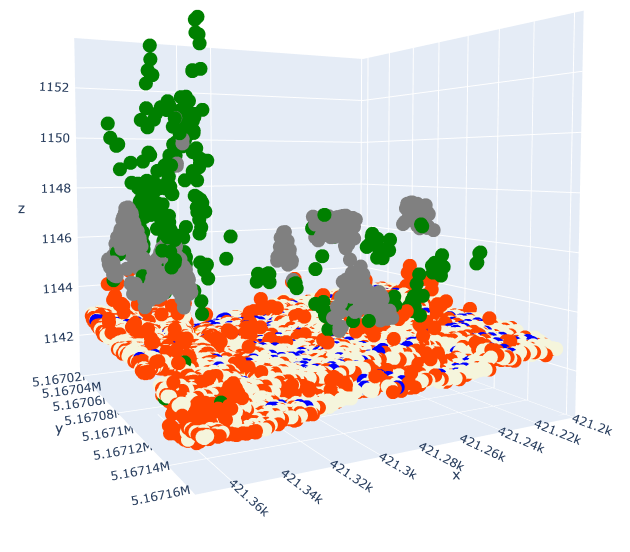

## Install packages

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install plotly
!pip install laspy[lazrs,laszip]
!pip install raster_tools
!pip install stackstac
!pip install planetary_computer
!pip install pystac_client
!pip install leafmap xarray_leaflet
!pip install localtileserver

## Get supporting python file

In [ ]:
import gdown, zipfile

url='https://drive.google.com/file/d/1dy7bnPKc4BPvHlH-PkrObXwb-SW9nv7n/view?usp=sharing'
outfl= r'./rs_las.py'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

## The Process
### We will be using 3dep point cloud data to create delayed processing Raster objects of multiple vegetation metrics. As part of this notebook we will explore the coding behind converting point cloud data into delayed Raster objects. The metrics we will create from the lidar data include:
- zmean : mean height
- zmax : max height
- zp10, zp25, zp50, zp75, zp90, zp99 : percentile
- zfcc : canopy cover
- zfsc : shrub cover
- zcv : coefficient of variation

### Steps
1. Import python libraries and download laz files
2. Visualize laz file boundaries
3. Create laz predictors 
4. Visualize surface metrics
5. Save Raster Surfaces
6. Explore rs_las and how point clouds are being processed

## Step 1: Import libraries and get data
### Import libary

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import rs_las

from dask.diagnostics import ProgressBar


from raster_tools import Raster

from shapely.geometry import shape
from shapely.ops import transform

import leafmap.leafmap as leafmap

### Get the laz data from Planetary Computer
#### We will be using laz files downloaded from Planetary Computer for a small area around Helena MT. To download the laz files run the following cell or work through the [LidarDownload.ipynb](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarDownload.ipynb) notebook.

In [ ]:
import planetary_computer
import pystac_client
import requests

loc = {"type": "Point", "coordinates": [-112.027, 46.64]}
geom = shape(loc)

catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

search = catalog.search(collections=["3dep-lidar-copc"], intersects=geom.buffer(0.01))
ic = search.get_all_items()

#create a output folder if it does not already exist

output_folder= './lidar_cloud'
if(not os.path.exists(output_folder)): os.mkdir(output_folder)

for tile in ic:
        url = tile.assets["data"].href
        nm = tile.id + '.copc.laz'
        print('downloading ' + nm)
        r=requests.get(url,allow_redirects=True)
        open(output_folder+'/'+nm,'wb').write(r.content)

## Step 2: Visualize the las file points and boundaries
### Setup the grid scheme and display the boundary of each tile in folium
- Read the tile boundary and create polygons (rs_las.build_extents)
- Create a systematic grid based on a defined spatial resolution (xsteps, ysteps)
- Plot the results of the geopandas dataframe in folium

In [ ]:
%%time

laz_dir = './lidar_cloud'
laz_files_lst=[]
for f in os.listdir(laz_dir):
    if f[-4:]=='.laz': laz_files_lst.append(laz_dir+"/"+f)

res=30

gdf=rs_las.build_extents(laz_files_lst)
xmin,ymin,xmax,ymax=gdf.total_bounds

xsteps=np.arange(xmin,xmax,res)
ysteps=np.arange(ymin,ymax,res)


### Visualize first 10,000 points from tile 3 of the point cloud in an interactive display (plotly)

In [ ]:
import plotly.express as px
import laspy

las = laspy.read(laz_files_lst[3])

#Import LAS into numpy array (X=raw integer value x=scaled float value)
xyz=las.xyz
l_atts = {
    'intensity':np.array(las.intensity).transpose(),
    'classification':np.array(las.classification).transpose(),
    'return_number':np.array(las.return_number).transpose(),
    'number_of_returns':np.array(las.number_of_returns).transpose(),
    'scane_angle':np.array(las.scan_angle).transpose()
}

#Transform to pandas DataFrame
lidar_df=gpd.GeoDataFrame(l_atts,geometry=gpd.points_from_xy(xyz[:,0],xyz[:,1],xyz[:,2]),crs=rs_las.get_crs(laz_files_lst[0]))
display(lidar_df)

nums= [1,  2,  4, 6,  7, 10, 11]

clrs= ['blue','beige','green','grey','purple','orange','orangered']

l_sub=lidar_df.iloc[:10000]
cdic={nums[i]: clrs[i] for i in range(len(nums))}
fig = px.scatter_3d(l_sub,x=l_sub.geometry.x,y=l_sub.geometry.y,z=l_sub.geometry.z,color='classification',color_discrete_map=cdic,width=1600, height=800)
fig.show()

### Plot the las tile boundaries

In [ ]:
import folium
from folium import plugins

display(gdf)

m=gdf.explore(name='Tiles',color='orange',style_kwds={'fill':False})
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(m)
folium.LayerControl().add_to(m)
fs=plugins.Fullscreen()
dr=plugins.Draw()
lc=plugins.LocateControl()
ms=plugins.MeasureControl(position='bottomleft')
msp=plugins.MousePosition()
ms.add_to(m)
msp.add_to(m)
lc.add_to(m)
dr.add_to(m)
fs.add_to(m)
m

### Exercise 1: Plot first 10,000 las points for tile 2
- plot the boundary of those 10,000 las points over Open Street Maps background

## Step 3: Create Las Predictors Surfaces (Raster objects 30m)

- zmean
- zmax
- zp10, zp25, zp50, zp75, zp90, zp99
- zfcc
- zfsc
- zcv

### Use [rs_las](./rs_las.py) to create the metrics (aggtypes)

In [ ]:
%%time
aggtypes=['mean','max','quantile:0.1,0.25,0.5,0.75,0.9,0.99','zfcc','zfsc','zcv']
rs_z=rs_las.get_raster(gdf,res,aggtypes)
rs_z.xrs

## Step 4: Visualize surfaces
### as plots

In [ ]:
#compute the data
with ProgressBar():
    vls=rs_z.xrs.compute()

#Visualize surfaces as plots
for r in range(vls.shape[0]):
    vls[r].plot(figsize=(10,10),robust=True)

## Step 5: Save raster surfaces

In [ ]:
outname='Lidar_30_metrics.tif'
vls2=Raster(vls.rio.reproject("epsg:4326"))
b=((vls2>0) & (vls2<635))
vls3=vls2.where(b,0).set_null_value(0)
vls3.save(outname)


### Dynamically visualize outputs (Leafmap)

In [ ]:
m = leafmap.Map()
m.add_tile_layer(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', name = 'Esri Imagery',attribution='ESRI')
m.add_raster(outname,bands=[11,10,9], layer_name='Lidar Metrics (11,10,9)')
m.add_raster(outname,bands=[11], layer_name='Lidar Metrics (11)')
m.add_raster(outname,bands=[10], layer_name='Lidar Metrics (10)')
m.add_raster(outname,bands=[9], layer_name='Lidar Metrics (9)')
m

### Exercise 2: Resolution
- change the resolution from 30 m to 5 m and rerun
- What happend?

## Step 6: Explore [rs_las.py](./rs_las.py)
- what is @jit mean?
- what does filter_las do?
- what does get_crs do?
- what does build_extents do?
- what is interp_values def do?
- why is there a interp_pts_array function?
- what does the _ mean?
- what does get_raster do?
- what does calc_glcm do?
- How does dask mapping work?

### Exercise 3: Add functionality
- create a new summary function and add it to the list of aggregation techniques
- use your new function to process the lidar point cloud data and visualize the results

# This ends the Process Lidar data from USGS 3Dep notebook
## Check out the other notebooks:
- https://github.com/jshogland/SpatialModelingTutorials/tree/main/Notebooks
## References
- Spatial Modeling Notebooks:  https://github.com/jshogland/SpatialModelingTutorials
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html